<a href="https://colab.research.google.com/github/githubpradeep/notebooks/blob/main/MobileVLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Meituan-AutoML/MobileVLM.git
%cd MobileVLM

Cloning into 'MobileVLM'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 65 (delta 15), reused 41 (delta 8), pack-reused 0
Receiving objects: 100% (65/65), 190.93 KiB | 8.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/MobileVLM


In [ ]:
!pip install -r requirements.txt


In [5]:
import sys
import torch
import argparse
from PIL import Image
from pathlib import Path

sys.path.append('/content/MobileVLM')

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria
from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN

[2024-01-05 15:34:44,229] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [33]:
model_name = 'mtgv/MobileVLM-3B'
tokenizer, model, image_processor, context_len = load_pretrained_model(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.07G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [34]:
import requests
import matplotlib.pyplot as plt


In [35]:
def generate(query, img_url):
    images = [Image.open(requests.get(img_url, stream=True).raw).convert('RGB')]
    plt.imshow(images[0])
    images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)

    conv = conv_templates['v1'].copy()
    conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + query)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    # Input
    input_ids = (tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda())
    stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)
    # Inference
    temperature = 0.2
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            top_p=None,
            num_beams=1,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    # Result-Decode
    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]
    print(f"🚀 {model_name}: {outputs.strip()}\n")

🚀 mtgv/MobileVLM-3B: The breed of this dog is a brown and white dog.



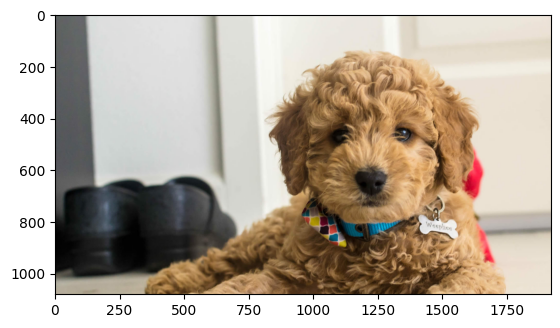

In [37]:
query = "What's the breed of this dog?"
image = 'https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0'
generate(query, image)

🚀 mtgv/MobileVLM-3B: The unusual aspect of this image is that a man is working on a laundry machine while sitting on top of a moving yellow taxi cab. Typically, laundry machines are found indoors, in a laundromat or a similar facility, and not on the back of a moving taxi. This scene is unconventional and creates an interesting juxtaposition between the everyday activity of laundry and the unexpected presence of a person working on a laundry machine while being transported by a taxi.



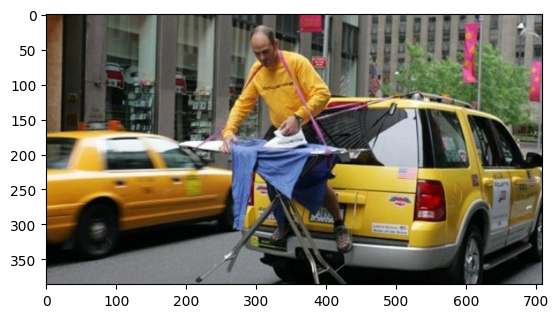

In [38]:
query = 'What is unusual about this image?'
image = 'https://i.pinimg.com/736x/6e/71/0d/6e710de5084379ba6a57b77e6579084f.jpg'
generate(query, image)

🚀 mtgv/MobileVLM-3B: The lady is standing next to her car, which is parked on the side of a road. She is talking on her cell phone.



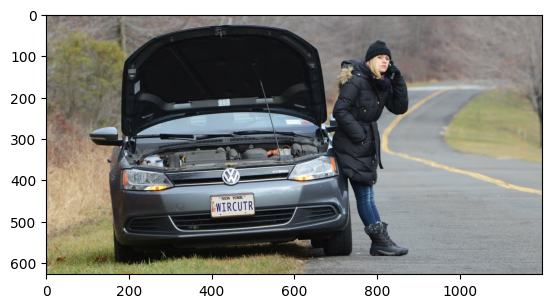

In [39]:
image='https://cdn.thewirecutter.com/wp-content/uploads/2016/01/gear-for-roadside-emergencies-2x1-fullres-1.jpg?auto=webp&quality=75&crop=1.91:1&width=1200'
query = 'What is the lady doing?'
generate(query, image)

🚀 mtgv/MobileVLM-3B: The lady is likely calling to report the car's flat tire, as she is standing next to the car on the side of the road. She might be trying to notify someone of the situation or seek assistance in resolving the issue.



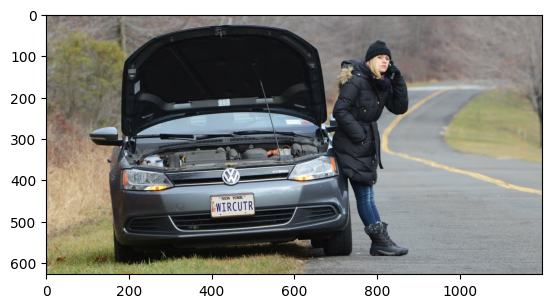

In [40]:
image='https://cdn.thewirecutter.com/wp-content/uploads/2016/01/gear-for-roadside-emergencies-2x1-fullres-1.jpg?auto=webp&quality=75&crop=1.91:1&width=1200'
query = 'Why is the lady calling?'
generate(query, image)